In [ ]:
# Model training of text classiffiers using logreg, svm, mlp 
# Violeta Berdejo-Espinola, Akos Hajas, Nan Ye
# November 2024

# read data

In [1]:
import mpu

# x data
x_raw = mpu.io.read('../data/v3/corpus_raw.pickle')
x = mpu.io.read('../data/v3/corpus_clean.pickle')

# pos, negs
pos = mpu.io.read('../data/v3/pos.pickle')
neg = mpu.io.read('../data/v3/neg.pickle')

# y 

y = mpu.io.read('../data/v3/y.pickle')

In [2]:
x[:3], x_raw[:3], y[:20]

(['discriminación hez puma puma concolor jaguar panthera onco identificación ácido biliar técnica monitoreo carnívoro silvestr frecuente uso hez fuente información estudio registro fauna aquel ser gran utilidad grande carnívoro ser difícil ver embargo identificación específico siempre correcto especialmente especie simpátrica caso puma jaguar altitud intermedio parque nacional amborar bolivia caso estudio resolver problema haber utilizar simple técnica laboratorio cromatografía capa fino tlc sigla inglés tlc permitir identificación específico determinación cromatográfico ácido biliar intensidad color presencia ausencio ácido biliar hez varíar especie trabajo haber comparar patrón ácido biliar muestra obtenido parque nacional amborar muestra testigo obtenido zoológico estación faunística resultado mostrar patrón ácido biliar puma compuesto ácido litocólico dehydrocólico deoxicólico quenodeoxicólico cólico glicocólico cuatro ácido identificado patrón ácido biliar jaguar compuesto ácido l

In [3]:
# calculate weights

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 
weight_for_class_0 +weight_for_class_1 

47.352851666248284

# split data

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_raw, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
from collections import Counter

counter = Counter()

for i in y_test_r:
    counter[i] +=1
    
print(counter)

Counter({0: 4375, 1: 47})


# instantiate feature extractors, embedding models, resamplers, models 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer # uses one-dim array of strings ~ shape (n,)
from sklearn.feature_extraction.text import CountVectorizer # returns arrays

vect_cv = CountVectorizer()
vect_tfidf = TfidfVectorizer()

model_mpnet = 'paraphrase-multilingual-mpnet-base-v2'
model_distill = 'distiluse-base-multilingual-cased-v1'

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN 

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')
ada = ADASYN(random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42)
svm = SVC(kernel='linear')
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True)
mlp = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
# mlp_t = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(5,), learning_rate='invscaling',learning_rate_init=1, solver='sgd', random_state=42, max_iter=400)

# function to train eval models

In [6]:
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, precision_score, recall_score

import pandas as pd

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# TF TFIDF baseline and weighted

def train_eval_tf_tfidf(x_train, y_train, x_test, y_test, text_length, kfold):
    
    def run_estimator(estimator, feature_extractor, balanced):
        
        pipeline = Pipeline([("vectorizer", feature_extractor),
                             ("estimator", estimator)
                            ])
    
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') # cross val splits the data and then applies the pipeline steps

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': pipeline['estimator'],
            'Feature_extraction': pipeline['vectorizer'],
            'Weighting': 'Weighted' if balanced else 'None',
            'CV': kfold,
            'Text_length': text_length,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }


    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for estimator in [logreg, svm]:
            all_scores.append(run_estimator(estimator, feature_extractor, False))
            
        for estimator in [logreg_weight, svm_weight]: 
            all_scores.append(run_estimator(estimator, feature_extractor, True))

    return all_scores

In [7]:
# embeddings baseline and weighted

def train_eval_embeddings(x_train, y_train, x_test, y_test, text_length, kfold):

    def run_estimator(estimator, balanced):
        
        pipeline = make_pipeline(
            SentenceEncoder(embedding_model),
            estimator
        )
        
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': estimator,
            'Feature_extraction': embedding_model,
            'Weighting': 'Weighted' if balanced else None,
            'CV': kfold,
            'Text_length': text_length,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }

    all_scores = []
    
    for embedding_model in [model_distill]: #model_mpnet,]:
        
            # for estimator in [logreg, svm, mlp]:#, mlp_t]:
            #     all_scores.append(run_estimator(estimator, False))
                
            for estimator in [logreg_weight, svm_weight]: 
                all_scores.append(run_estimator(estimator, True))

    return all_scores

In [ ]:
# TF TFIDF resampled

def train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test, text_length, kfold):
    
    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for resampler in [rus, ros, ada]:
        
            for estimator in [logreg, svm, mlp]:
        
                pipeline = Pipeline([("vectorizer", feature_extractor),
                                    ("resampler", resampler),
                                    ("estimator", estimator)
                                    ])
        
                y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

                pipeline.fit(x_train, y_train)
                
                y_train_pred = pipeline.predict(x_train)

                y_test_pred = pipeline.predict(x_test)

                scores = {
                    'Classifier': pipeline['estimator'],
                    'Feature_extraction': pipeline['vectorizer'],
                    'Weighting': pipeline['resampler'],
                    'CV': kfold,
                    'Text_length': text_length,
                    'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
                    'F1_tr': round(f1_score(y_train, y_train_pred), 3),
                    'F1_ts': round(f1_score(y_test, y_test_pred), 3),
                    'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
                    'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
                    'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
                    'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
                    'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
                    'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
                }
    
                all_scores.append(scores)

    return all_scores

In [ ]:
# embeddings resampled

def train_eval_embedding_resampled(x_train, y_train, x_test, y_test, text_length, kfold, embed_model):
    
    all_scores = []
    
    pipeline = make_pipeline(
        SentenceEncoder(embed_model),
        RandomOverSampler(random_state=42, sampling_strategy='not majority'),
        MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
    )
                                
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': mlp,
        'Feature_extraction': embed_model,
        'Weighting': ros,
        'CV': kfold,
        'Text_length': text_length,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
    }

    all_scores.append(scores)

    return all_scores

# train eval models

In [ ]:
# TF TFIDF baseline and weighted

df1 = pd.DataFrame(train_eval_tf_tfidf(x_train, y_train, x_test, y_test,'Title_Abstract',2))

In [ ]:
# embeddings baseline and weighted

df2 = pd.DataFrame(train_eval_embeddings(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2))

In [ ]:
df2.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)

In [ ]:
# TF TFIDF resampled

df3 = pd.DataFrame(train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test,'Title_Abstract',2))

In [ ]:
# embeddings resampled

df4 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2, model_mpnet))
df5 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,'Title_Abstract',2, model_distill))

# cocatenate and save model results

In [ ]:
res = pd.concat([df1,df2,df3,df4,df5])
res = res.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)
res 

In [ ]:
# save model scores

# res.to_csv('../results/april/model_scores/model_scores.csv')

In [40]:
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=0.001)
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True) #, C=0.1)

In [ ]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, solver):
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed

        
    Returns:
    --------
    Dictionary with scores.
    Log losss values for test and train set.
    Array of test set predicitons
    """
    
    pipeline = make_pipeline(
        # SentenceEncoder('distiluse-base-multilingual-cased-v1'),
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        logreg_weight

    )

    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': 'Log_reg',
        'Feature_extraction': 'multilingual embedding model',
        'Weighting': 'Weighted',
        'CV': kfold,
        'Solver': solver,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    # log loss train set
    y_pred_tr = pipeline.predict_proba(x_train) 
    logloss_tr = log_loss(y_train, y_pred_tr) 

    # log loss test set
    y_pred_ts = pipeline.predict_proba(x_test)  
    logloss_ts = log_loss(y_test, y_pred_ts)

    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
    
    # Get predicted probabilities
    probs = pipeline.predict_proba(x_test_r)[:, 1]

    # Set a custom threshold
    threshold = 0.4  # Change this value to shift the decision boundary
    y_pred = (probs >= threshold).astype(int)

    # Evaluate results
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix at threshold =", threshold)
    print(cm)
 
    return scores, y_pred_ts, logloss_tr, logloss_ts

In [14]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 5, 'liblinear') #logreg

loss training set: 0.161392598590208, 
loss test set 0.17819556540488296
confusion matrix train set:
[[4147  228]
 [   0   47]]
confusion matrix test set:
[[1033   61]
 [   5    7]]


In [15]:
scores

{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 5,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.18,
 'F1_tr': 0.292,
 'F1_ts': 0.175,
 'Precision_tr_cv': 0.105,
 'Precision_tr': 0.171,
 'Precision_ts': 0.103,
 'Recall_tr_cv': 0.617,
 'Recall_tr': 1.0,
 'Recall_ts': 0.583}

In [ ]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 5, 'sag') #logreg mpnet

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_ite

loss training set: 3.5858732890942884, 
loss test set 3.547950836054177
confusion matrix train set:
[[3099 1276]
 [   3   44]]
confusion matrix test set:
[[766 328]
 [  2  10]]


In [23]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 5, 'liblinear') #logreg mpnet

loss training set: 0.16177061341016308, 
loss test set 0.17098180988527306
confusion matrix train set:
[[4085  290]
 [   0   47]]
confusion matrix test set:
[[1023   71]
 [   3    9]]


In [26]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 5, 'linear') #svm mpnet

loss training set: 0.03142754220294496, 
loss test set 0.04569813910849828
confusion matrix train set:
[[4220  155]
 [   0   47]]
confusion matrix test set:
[[1053   41]
 [   6    6]]


In [30]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 3, 'lbfgs') #logreg mpnet

loss training set: 0.1606333841672579, 
loss test set 0.16818419079007427
confusion matrix train set:
[[4086  289]
 [   0   47]]
confusion matrix test set:
[[1025   69]
 [   3    9]]


In [31]:
scores

{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 3,
 'Solver': 'lbfgs',
 'F1_tr_cv': 0.159,
 'F1_tr': 0.245,
 'F1_ts': 0.2,
 'Precision_tr_cv': 0.092,
 'Precision_tr': 0.14,
 'Precision_ts': 0.115,
 'Recall_tr_cv': 0.596,
 'Recall_tr': 1.0,
 'Recall_ts': 0.75}

In [34]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'lbfgs') #logreg mpnet c=0.01

loss training set: 0.47986373039031055, 
loss test set 0.48095663225297614
confusion matrix train set:
[[3485  890]
 [   4   43]]
confusion matrix test set:
[[890 204]
 [  2  10]]


In [45]:
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=0.01)
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'liblinear') 
scores

Confusion Matrix at threshold = 0.4
[[627 467]
 [  0  12]]
loss training set: 0.48858494861758506, 
loss test set 0.4900895544422995
confusion matrix train set:
[[3430  945]
 [   4   43]]
confusion matrix test set:
[[873 221]
 [  2  10]]


{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.078,
 'F1_tr': 0.083,
 'F1_ts': 0.082,
 'Precision_tr_cv': 0.041,
 'Precision_tr': 0.044,
 'Precision_ts': 0.043,
 'Recall_tr_cv': 0.851,
 'Recall_tr': 0.915,
 'Recall_ts': 0.833}

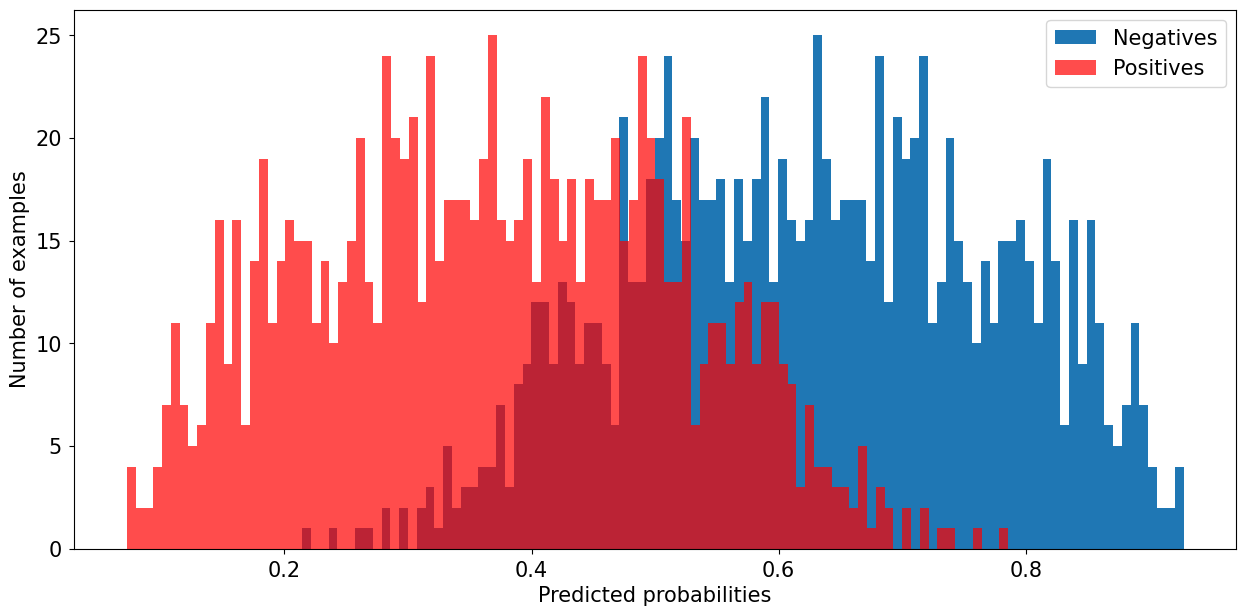

In [46]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_pre_ts[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_pre_ts[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
# plt.savefig('../results/model_scores/predicted_proba_logreg_ts.png', dpi=800)
plt.show() 

In [41]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'liblinear') #logreg mpnet c=0.001
scores

loss training set: 0.6455120638785955, 
loss test set 0.6473044595363218
confusion matrix train set:
[[3122 1253]
 [   4   43]]
confusion matrix test set:
[[790 304]
 [  2  10]]


{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.058,
 'F1_tr': 0.064,
 'F1_ts': 0.061,
 'Precision_tr_cv': 0.03,
 'Precision_tr': 0.033,
 'Precision_ts': 0.032,
 'Recall_tr_cv': 0.83,
 'Recall_tr': 0.915,
 'Recall_ts': 0.833}

In [35]:
x_train_rr, x_test_rr, y_train_rr, y_test_rr = train_test_split(x_raw, y, test_size=0.20, random_state=42)

In [36]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_rr, y_train_rr, x_test_rr, y_test_rr, 2, 'lbfgs') #logreg mpnet c=0.01

loss training set: 0.45975337886363415, 
loss test set 0.4716875049420944
confusion matrix train set:
[[3617  760]
 [   1   44]]
confusion matrix test set:
[[875 217]
 [  3  11]]
